In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
Image_Size= 256
Batch_Size = 20
num_classes = 2

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset/real_and_fake_face",
    shuffle=True,
    image_size=(Image_Size, Image_Size),
    batch_size=Batch_Size
)


Found 2041 files belonging to 2 classes.


In [ ]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = splitting_dataset_tf(dataset)

In [ ]:
print(len(train_ds), len(val_ds))

82 20


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(Image_Size, Image_Size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Nadam

#learning_rate = 0.001  # İstediğiniz learning rate'i burada ayarlayın

#optimizer = Nadam(learning_rate=learning_rate)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=5,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
82/82 [==============================] - 442s 5s/step - loss: 18.3438 - accuracy: 0.5188 - val_loss: 2.0988 - val_accuracy: 0.6025
Epoch 2/5
82/82 [==============================] - 346s 4s/step - loss: 2.9010 - accuracy: 0.5423 - val_loss: 0.6754 - val_accuracy: 0.5600
Epoch 3/5
82/82 [==============================] - 344s 4s/step - loss: 0.7218 - accuracy: 0.5503 - val_loss: 0.6784 - val_accuracy: 0.5925
Epoch 4/5
82/82 [==============================] - 343s 4s/step - loss: 0.7087 - accuracy: 0.5324 - val_loss: 0.6682 - val_accuracy: 0.5550
Epoch 5/5
82/82 [==============================] - 343s 4s/step - loss: 0.6923 - accuracy: 0.5361 - val_loss: 0.6603 - val_accuracy: 0.6475


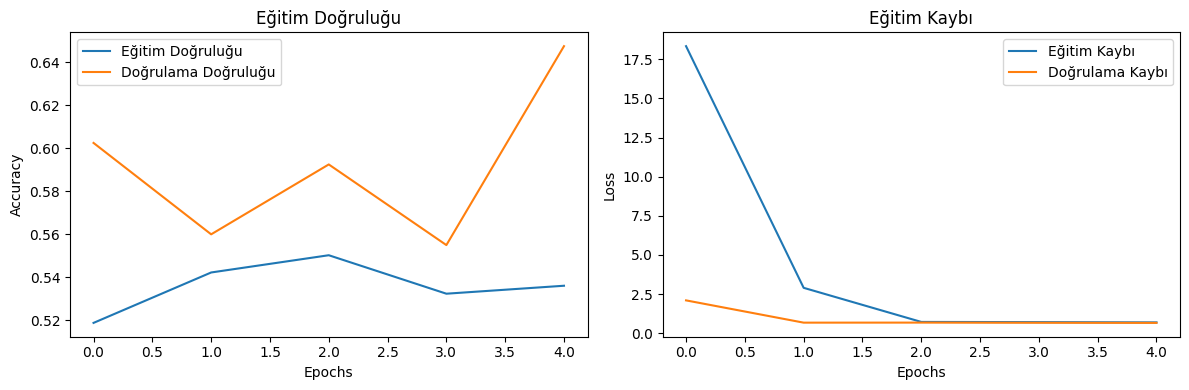

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Eğitilmiş modeli kaydetme
model.save('inceptionv3_real_fake_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 67s 3s/step


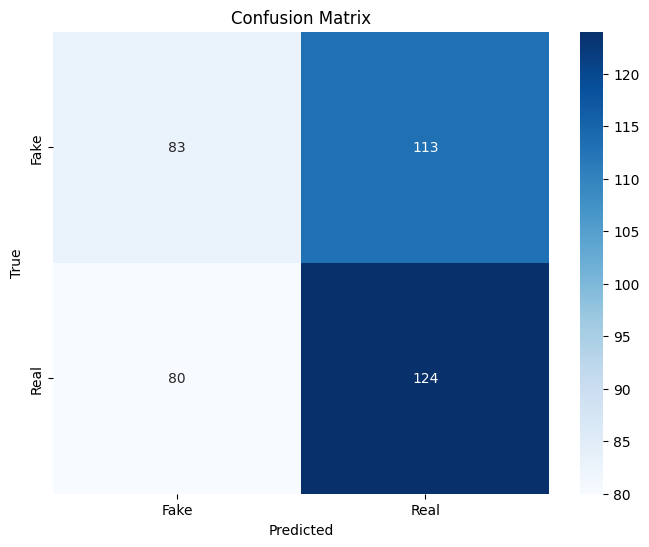

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Validation veri kümesi üzerinde tahminlerin alınması
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketlerin alınması
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Confusion matrix oluşturma
cm = confusion_matrix(y_true, y_pred_classes)

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Doğruluk değerini hesapla
dogruluk = accuracy_score(y_true, y_pred_classes)

# Sonucu yüzde olarak göster
dogruluk_yuzde = dogruluk * 100
print(f"Model doğruluğu: {dogruluk_yuzde:.2f}%")

Model doğruluğu: 51.75%


In [ ]:
from sklearn.metrics import classification_report

# Sınıflandırma raporu oluşturma
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.51      0.42      0.46       196
           1       0.52      0.61      0.56       204

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.51       400
weighted avg       0.52      0.52      0.51       400



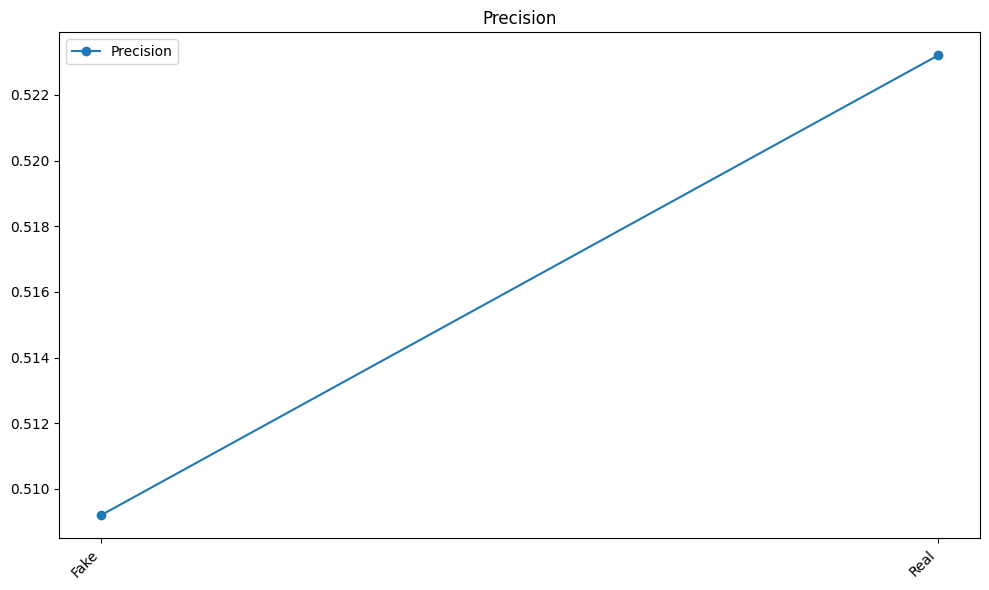

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
precision = precision_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,precision, marker='o', label='Precision')
plt.title('Precision')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

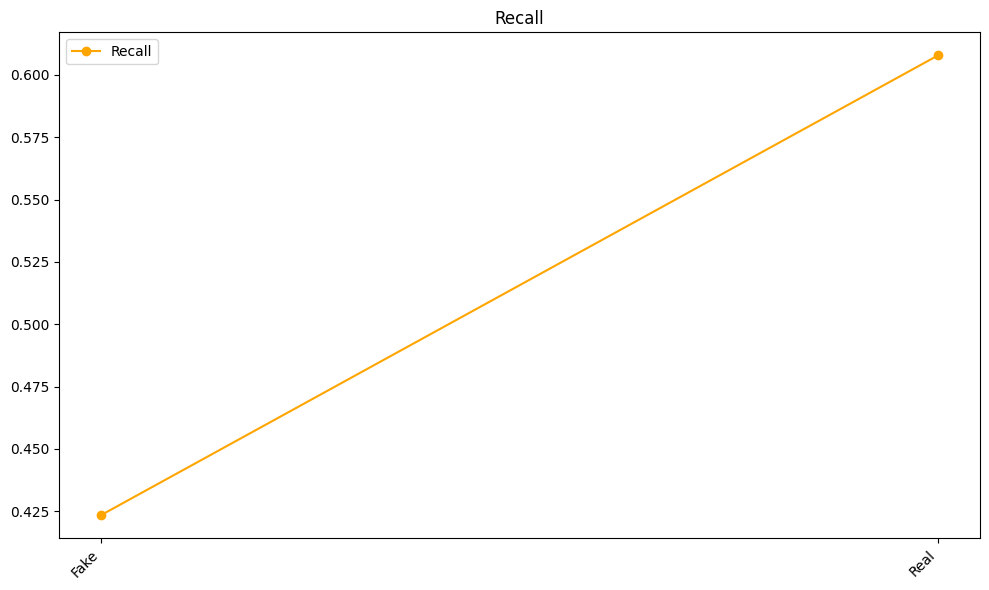

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
recall = recall_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,recall, marker='o',color='orange', label='Recall')
plt.title('Recall')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

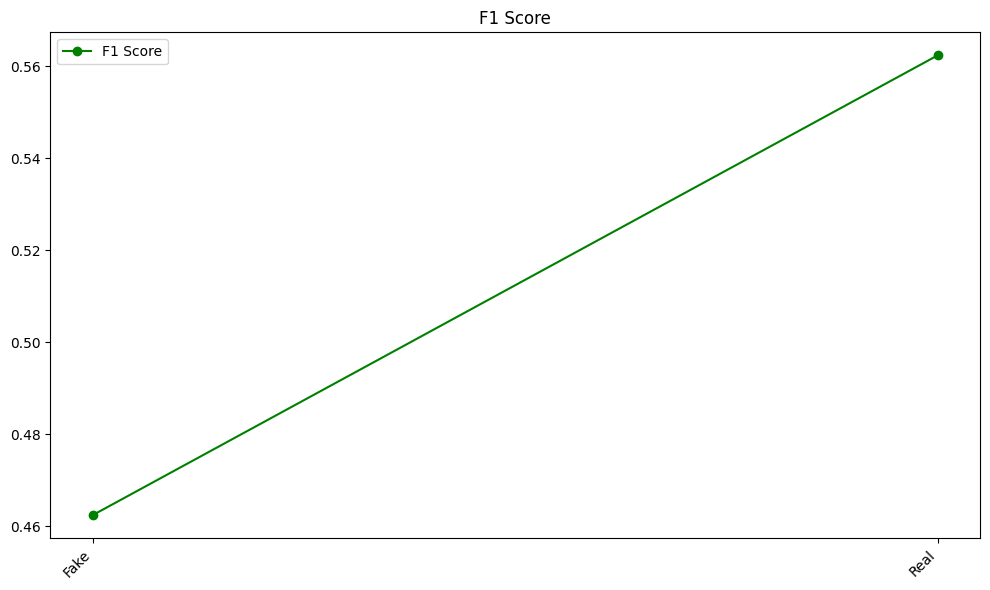

In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
f1 = f1_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,f1, marker='o',color='green', label='F1 Score')
plt.title('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

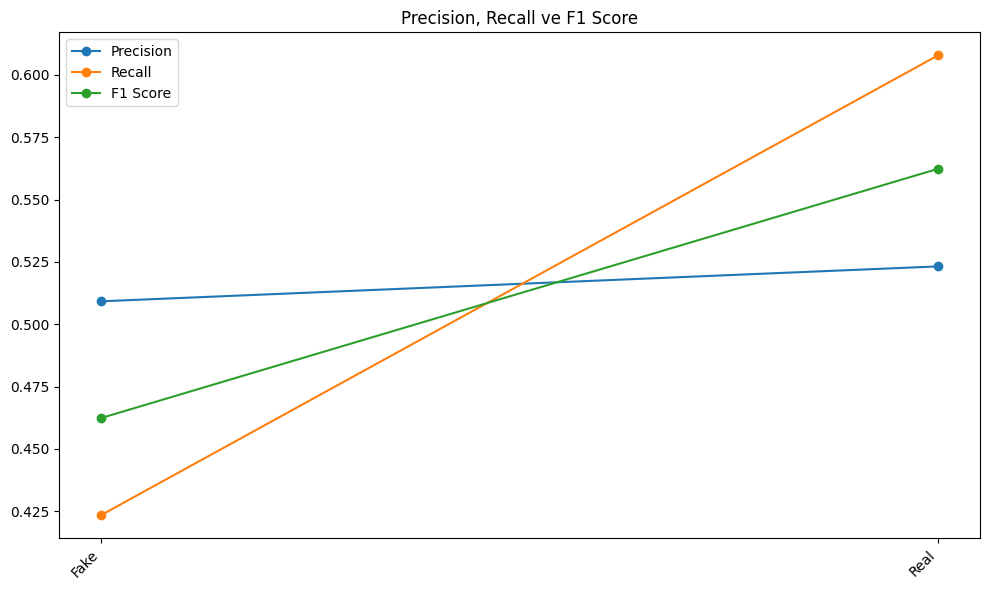

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,precision, marker='o', label='Precision')
plt.plot(folders,recall, marker='o', label='Recall')
plt.plot(folders,f1, marker='o', label='F1 Score')
plt.title('Precision, Recall ve F1 Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()